# Foursqare EDA and Starter Notebook
This notebook was created during a live stream on twitch. [Check out my channel here](https://www.twitch.tv/medallionstallion_)


In [1]:
!pip install nb_black > /dev/null

In [2]:
%load_ext lab_black
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle
import plotly.express as px
import warnings

warnings.filterwarnings("ignore")
plt.style.use("ggplot")

color_pal = plt.rcParams["axes.prop_cycle"].by_key()["color"]
color_cycle = cycle(plt.rcParams["axes.prop_cycle"].by_key()["color"])

## Loading the data
I made a parquet version of the training data for faster loading. As an example I'll load the csv versions and parquet versions so we can compare how long it takes to load. It actually didn't end up being that much faster, but still saves a few seconds.

In [3]:
%%time
train = pd.read_csv('../input/foursquare-location-matching/train.csv')
test = pd.read_csv('../input/foursquare-location-matching/test.csv')
ss = pd.read_csv('../input/foursquare-location-matching/sample_submission.csv')
pairs = pd.read_csv('../input/foursquare-location-matching/pairs.csv')

CPU times: user 11.8 s, sys: 1.5 s, total: 13.3 s
Wall time: 17.4 s


In [4]:
%%time
train = pd.read_parquet('../input/foursquare-location-matching-parquet/train.parquet')
test = pd.read_parquet('../input/foursquare-location-matching-parquet//test.parquet')
ss = pd.read_parquet('../input/foursquare-location-matching-parquet/sample_submission.parquet')
pairs = pd.read_parquet('../input/foursquare-location-matching-parquet/pairs.parquet')

CPU times: user 4.45 s, sys: 1.93 s, total: 6.38 s
Wall time: 8.46 s


In [5]:
# Print the shape of each file
train.shape, test.shape, ss.shape, pairs.shape

((1138812, 13), (5, 12), (5, 2), (578907, 25))

## The Data
- `train.csv` - The training set, comprising eleven attribute fields for over one million place entries. Main keys are `id` and `point_of_interest`
- `pairs.csv` - A pregenerated set of pairs of place entries designed to improve detection of matches.
- `test.csv` and example 5 rows of what the real test set with look like.
- `sample_submission.csv` example of the format of the submission that is expected.


## What's Missing?

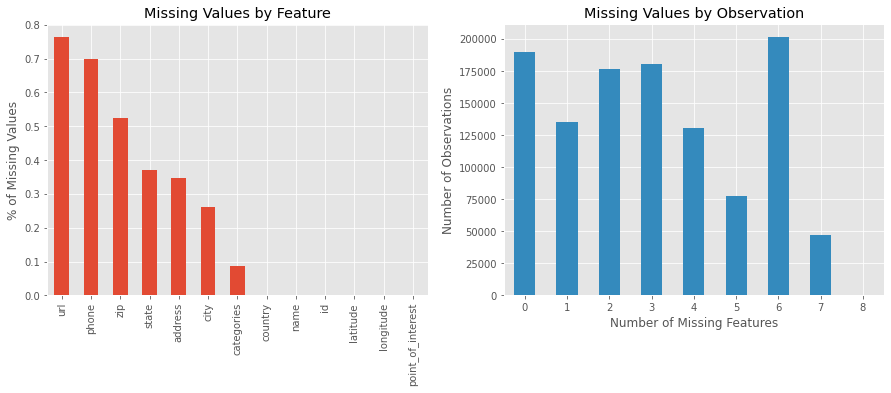

In [6]:
# How many missing values for each example
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
train.isna().mean().sort_values(ascending=False).plot(
    kind="bar", title="Missing Values by Feature", ax=axs[0]
)
axs[0].set_ylabel("% of Missing Values")

train.isna().sum(axis=1).value_counts().sort_index().plot(
    ax=axs[1], title="Missing Values by Observation", kind="bar", color=color_pal[1]
)

axs[1].set_xlabel("Number of Missing Features")
axs[1].set_ylabel("Number of Observations")
plt.xticks(rotation=0)
plt.show()

## Train features
The training dataset has 1138812 examples.
- id
- name ?
- lat/long
- address, city, state, zip & country
- url
- phone
- categories

There are 52578 unique categories


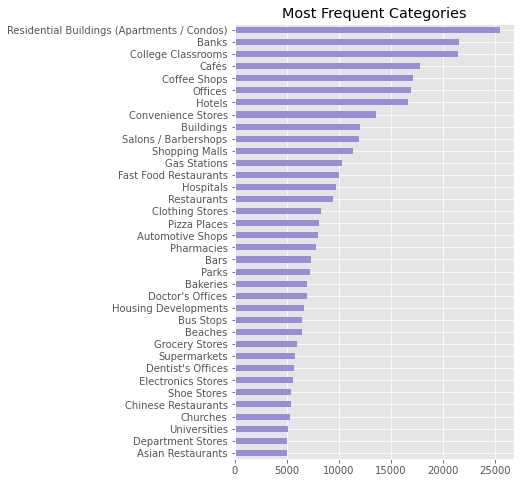

In [7]:
print(f'There are {train["categories"].nunique()} unique categories')
# Take a look at the most frequent categories
train["categories"].value_counts().to_frame().query("categories > 5_000")[
    "categories"
].sort_values(ascending=True).plot(
    kind="barh", color=color_pal[2], title="Most Frequent Categories", figsize=(5, 8)
)
plt.show()

# Top 10 Values for Country/City/State etc.
Some things to note:
- US is the top country
- CA and NY are the top states
- There are some states that don't show up because of the font I'm using
- Singapore is the top city, suprisingly although NY is the top state, New York City is not the top city.
- Some of these zip codes look sus.

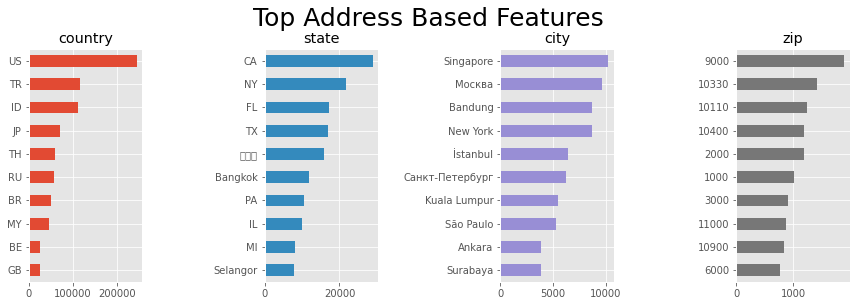

In [8]:
fig, axs = plt.subplots(1, 4, figsize=(12, 4))
for i, col in enumerate(["country", "state", "city", "zip"]):
    train[col].value_counts().head(10).sort_values(ascending=True).plot(
        kind="barh", ax=axs[i], color=next(color_cycle), title=col
    )
plt.tight_layout()
fig.suptitle("Top Address Based Features", y=1.05, fontsize=25)
plt.show()

# Map Out the Lat / Long by Category

There are way too many points to plot at once (at least at first). Lets plot the points from a single city. We will pick Singapore because it is the top city in the dataset. We will only show the top 5 categories and then bin everything else into "Other"

In [9]:
def plot_points(
    df,
    lat_col="latitude",
    lon_col="longitude",
    hover_name="name",
    color_col="categories_plot",
    hover_data=["categories", "id", "phone", "url"],
    zoom=9,
):
    df = df.copy()
    df = df.fillna("Missing")
    if color_col == "categories_plot":
        top_5_cats = df["categories"].value_counts().head(5).index.values.tolist()
        df["categories_plot"] = df["categories"]
        df.loc[~df["categories"].isin(top_5_cats), "categories_plot"] = "Other"
    fig = px.scatter_mapbox(
        df,
        lat=lat_col,
        lon=lon_col,
        hover_name=hover_name,
        hover_data=hover_data,
        color=color_col,
        labels="POI",
        zoom=zoom,
        height=600,
        width=800,
        opacity=0.9,
    )
    fig.update_layout(mapbox_style="stamen-terrain")
    fig.update_layout(margin={"r": 0, "t": 0, "l": 0, "b": 0})
    fig.update_layout(title_text="Points in Singapore")
    fig.show()


plot_points(train.query('city == "Singapore"'))

# Map and Color by Known Pairs
- The blue points below have known pairs
- The red points do not

In [10]:
train_sing = train.query('city == "Singapore"').reset_index(drop=True).copy()
# Find all the pair ids that exist
known_pair_ids = pd.concat(
    [pairs.query("match")["id_1"], pairs.query("match")["id_2"]]
).unique()
train_sing["is_pair_id"] = train_sing["id"].isin(known_pair_ids)

plot_points(train_sing, color_col="is_pair_id")

# Missing City Column Values
But wait! We are missing rows in Singapore that don't have a "city" column

Lets find the min/max lat and long values for singapore and include any points within this area even if they do not have a city feature. We will use the mean lat/lon +/- 3 std to filter to that area.

Dot colors in this plot show if the "City" value is missing.

In [11]:
min_max = train.query('city == "Singapore"')[["latitude", "longitude"]].agg(
    ["min", "max", "mean", "std"]
)

min_max

latitude   longitude
min   -7.811294   98.677472
max   22.312572  117.150117
mean   1.327829  103.849073
std    0.331130    0.269057

In [12]:
min_lat = min_max["latitude"]["min"]
max_lat = min_max["latitude"]["max"]
min_lon = min_max["longitude"]["min"]
max_lon = min_max["longitude"]["max"]

mean_lat = min_max["latitude"]["mean"]
mean_lon = min_max["longitude"]["mean"]
std_lat = min_max["latitude"]["std"]
std_lon = min_max["longitude"]["std"]

min_lat = mean_lat - (3 * std_lat)
max_lat = mean_lat + (3 * std_lat)
min_lon = mean_lon - (3 * std_lon)
max_lon = mean_lon + (3 * std_lon)

train_sing = train.query("latitude >= @min_lat and latitude <= @max_lat").query(
    "longitude >= @min_lon and longitude <= @max_lon"
)
train_sing["missing_city"] = train_sing["city"].isna()

plot_points(train_sing, color_col="missing_city")

# Better Understand the "Pairs.csv"
The data description says:
- `pairs.csv` - A pregenerated set of pairs of place entries from train.csv designed to improve detection of matches. You may wish to generate additional pairs to improve your model's ability to discriminate POIs.
    - `match` - Whether (True or False) the pair of entries describes a common POI.

I don't fully understand this yet. So to better understand I will take a look at the POI which occurs the most in the `pairs.csv` and plot those locations on a mpa.

In [13]:
pairs.shape, train.shape

((578907, 25), (1138812, 13))

In [14]:
true_pairs = pairs.query("match == True").reset_index(drop=True).copy()
# As an example, lets try to find the PIO
paired_ids = pd.concat([true_pairs["id_1"], true_pairs["id_2"]]).value_counts()

# Plotting Points of the Most Common "cluster" of pairs.
How are all these considered the same point?

In [15]:
most_common_pair = paired_ids.index[0]
# Locate pairs where the most common is one of the two ids
most_common_cluster = (
    true_pairs.loc[
        (true_pairs["id_1"] == most_common_pair)
        | (true_pairs["id_2"] == most_common_pair)
    ]
    .reset_index(drop=True)
    .copy()
)

common_cluster_ids = pd.concat(
    [most_common_cluster["id_1"], most_common_cluster["id_2"]]
).unique()

plot_points(train.query("id in @common_cluster_ids"), color_col="categories")

In [16]:
most_common_pair = paired_ids.index[1]
# Locate pairs where the most common is one of the two ids
most_common_cluster = (
    true_pairs.loc[
        (true_pairs["id_1"] == most_common_pair)
        | (true_pairs["id_2"] == most_common_pair)
    ]
    .reset_index(drop=True)
    .copy()
)

common_cluster_ids = pd.concat(
    [most_common_cluster["id_1"], most_common_cluster["id_2"]]
).unique()

plot_points(train.query("id in @common_cluster_ids"), color_col="categories")

In [17]:
most_common_pair = paired_ids.index[2]
# Locate pairs where the most common is one of the two ids
most_common_cluster = (
    true_pairs.loc[
        (true_pairs["id_1"] == most_common_pair)
        | (true_pairs["id_2"] == most_common_pair)
    ]
    .reset_index(drop=True)
    .copy()
)

common_cluster_ids = pd.concat(
    [most_common_cluster["id_1"], most_common_cluster["id_2"]]
).unique()

plot_points(train.query("id in @common_cluster_ids"), color_col="categories")